# ARIMA

In [59]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [8]:
def parser(x):
    return pd.datetime.strptime("200"+x, "%Y-%m")

In [14]:
series = pd.read_csv("shampoo_sales.csv", parse_dates=[0], date_parser=parser, header=0, index_col=0, squeeze=True)
series.head()

<ipython-input-8-3ea79fa19e65>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime("200"+x, "%Y-%m")


Month
2001-01-01    266.0
2001-02-01    145.9
2001-03-01    183.1
2001-04-01    119.3
2001-05-01    180.3
Name: Sales, dtype: float64

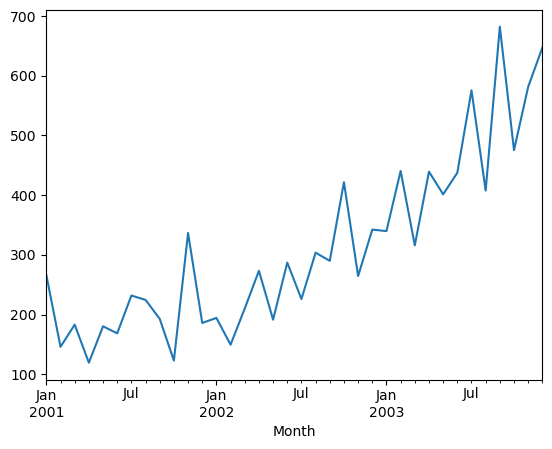

In [15]:
series.plot()
pyplot.show()

### help determine AR parameter

In [16]:
from pandas.plotting import autocorrelation_plot

In [71]:
series.index

PeriodIndex(['2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06',
             '2001-07', '2001-08', '2001-09', '2001-10', '2001-11', '2001-12',
             '2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06',
             '2002-07', '2002-08', '2002-09', '2002-10', '2002-11', '2002-12',
             '2003-01', '2003-02', '2003-03', '2003-04', '2003-05', '2003-06',
             '2003-07', '2003-08', '2003-09', '2003-10', '2003-11', '2003-12'],
            dtype='period[M]', name='Month')

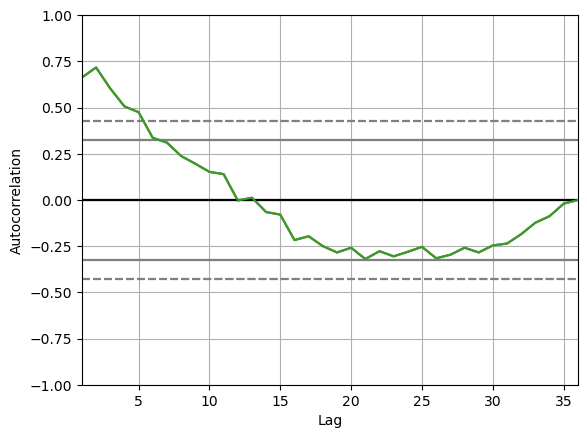

In [19]:
autocorrelation_plot(series)
pyplot.show()

> positive correlation for the first 12 lags.  
> statistically significant correlation for the first 5 lags   
> set AR parameter to 5

## Train Model

In [20]:
from statsmodels.tsa.arima.model import ARIMA

In [25]:
series.index = series.index.to_period("M")

In [26]:
series.head()

Month
2001-01    266.0
2001-02    145.9
2001-03    183.1
2001-04    119.3
2001-05    180.3
Freq: M, Name: Sales, dtype: float64

In [38]:
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

In [39]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Tue, 14 Sep 2021   AIC                            408.969
Time:                        16:53:39   BIC                            418.301
Sample:                    01-31-2001   HQIC                           412.191
                         - 12-31-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.798      -0.497       0.646
ar.L4          0.2519      0.340      0.742      0.458      -0.414       0.918
ar.L5          0.3344      0.210      1.593      0.111      -0.077       0.746
sigma2      4728.9608   1316.021      3.593      0.000    2149.607    7308.315
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.44   Prob(JB):                         0.62
Heteroskedasticity (H):               1.07   Skew:                             0.28
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
residuals = pd.DataFrame(model_fit.resid)
residuals.head()

,0
Month,
2001-01,266.000000
2001-02,-117.619577
2001-03,-51.500988
2001-04,-60.648283
2001-05,16.189738


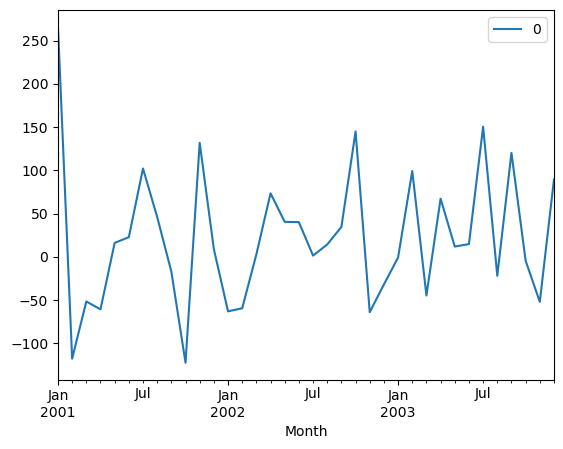

In [42]:
residuals.plot()
pyplot.show()

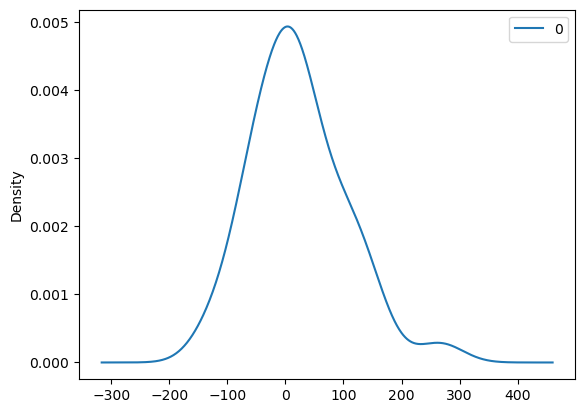

In [43]:
residuals.plot(kind="kde")
pyplot.show()

In [44]:
residuals.describe()

,0
count,36.000000
mean,21.936144
std,80.774430
min,-122.292030
25%,-35.040859
50%,13.147219
75%,68.848286
max,266.000000


> Ideally residuals have a mean of 0 and are normally distributed

# Forcasting with ARIMA

In [61]:
series.head()

Month
2001-01    266.0
2001-02    145.9
2001-03    183.1
2001-04    119.3
2001-05    180.3
Freq: M, Name: Sales, dtype: float64

In [62]:
X = series.values
split = int(len(X) * .66)
train, test = X[:split], X[split:]
history = [x for x in train]
predictions = []

In [63]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f"prediction: {yhat}, expected: {obs}") 

prediction: 343.2721802651713, expected: 342.3
prediction: 293.3296740602503, expected: 339.7
prediction: 368.6689556918126, expected: 440.4
prediction: 335.0447406370407, expected: 315.9
prediction: 363.22022156376084, expected: 439.3
prediction: 357.6453237220534, expected: 401.3
prediction: 443.0478352814394, expected: 437.4
prediction: 378.3656735776233, expected: 575.5
prediction: 459.4150204232002, expected: 407.6
prediction: 526.8908756956567, expected: 682.0
prediction: 457.23127455202575, expected: 475.3
prediction: 672.914943926937, expected: 581.3
prediction: 531.5414494085012, expected: 646.9


In [64]:
from sklearn.metrics import mean_squared_error

In [65]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
rmse

89.02105584444513

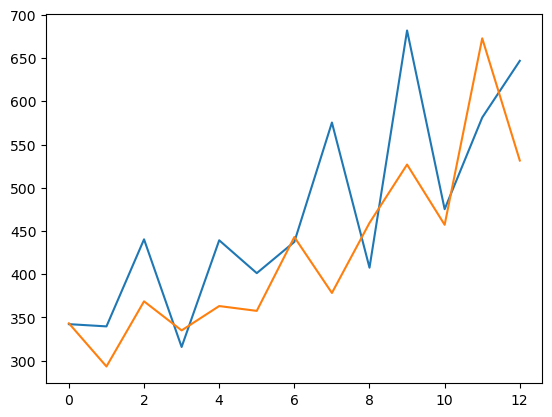

In [66]:
# plot
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()